In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd gdrive/MyDrive/Project/LSTM_Chem-master/

/content/gdrive/MyDrive/Project/LSTM_Chem-master


In [ ]:
ls

base_config.json                        LICENSE           results_finetune
cleanup_smiles.py                       lstm_chem/        results_finetune.csv
datasets/                               Pipfile           scatterplot_data.csv
example_Fine-tuning_for_TRPM8.ipynb     Pipfile.lock      train.py
example_Randomly_generate_SMILES.ipynb  README.md         Untitled0.ipynb
experiments/                            requirements.txt


In [ ]:
pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.4 MB/s 


In [ ]:
pip install bunch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bunch: filename=bunch-1.0.1-py3-none-any.whl size=7094 sha256=5a882602b5ba318d97ecfd615cce77d10a773646978dc857786ee51c1e917315
  Stored in directory: /root/.cache/pip/wheels/10/ad/12/a8818fda74a365129e0f316c41a12dead904b60534d2114448
Successfully built bunch


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole

from lstm_chem.utils.config import process_config
from lstm_chem.model import LSTMChem
from lstm_chem.finetuner import LSTMChemFinetuner
from lstm_chem.data_loader import DataLoader

In [ ]:
config = process_config('experiments/2022-05-17/LSTM_Chem/config.json')

modeler = LSTMChem(config, session='finetune')
finetune_dl = DataLoader(config, data_type='finetune')

finetuner = LSTMChemFinetuner(modeler, finetune_dl)
finetuner.finetune()

Loading model architecture from experiments/2022-05-17/LSTM_Chem/model_arch.json ...
Loading model checkpoint from experiments/2022-05-17/LSTM_Chem/checkpoints/LSTM_Chem-02-0.62.hdf5 ...
Loaded the Model.
loading SMILES...
done.
tokenizing SMILES...


100%|██████████| 7/7 [00:00<00:00, 10715.38it/s]

done.


Epoch 1/12
7/7 [==============================] - 11s 17ms/step - loss: 4.2974
Epoch 2/12
7/7 [==============================] - 0s 21ms/step - loss: 3.4113
Epoch 3/12
7/7 [==============================] - 0s 16ms/step - loss: 3.7103
Epoch 4/12
7/7 [==============================] - 0s 15ms/step - loss: 3.3990
Epoch 5/12
7/7 [==============================] - 0s 16ms/step - loss: 2.4287
Epoch 6/12
7/7 [==============================] - 0s 16ms/step - loss: 2.6689
Epoch 7/12
7/7 [==============================] - 0s 15ms/step - loss: 2.2420
Epoch 8/12
7/7 [==============================] - 0s 15ms/step - loss: 2.1458
Epoch 9/12
7/7 [==============================] - 0s 14ms/step - loss: 1.8517
Epoch 10/12
7/7 [==============================] - 0s 16ms/step - loss: 1.8915
Epoch 11/12
7/7 [==============================] - 0s 14ms/step - loss: 1.1820
Epoch 12/12
7/7 [==============================] - 0s 16ms/step - loss: 1.0512


In [ ]:
finetuned_smiles = finetuner.sample(num=200)

In [ ]:
with open('./datasets/known-CENP-E-Inhibitors.smi') as f:
    ksmiles = [l.rstrip() for l in f]
kmols = [Chem.MolFromSmiles(smi) for smi in ksmiles]

Kfps = []
for mol in kmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Kfps.append(fp)

Klen = len(Kfps)

In [ ]:
with open('./datasets/CENPE_inhibitors_for_fine-tune.smi') as f:
    fsmiles = [l.rstrip() for l in f]
fmols = [Chem.MolFromSmiles(smi) for smi in fsmiles]

Ffps, Fbvs = [], []
for mol in fmols:
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Fbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Ffps.append(fp)

Flen = len(Ffps)

In [ ]:
Sfps, Sbvs, smols = [], [], []
for smi in finetuned_smiles:
    mol = Chem.MolFromSmiles(smi)
    smols.append(mol)
    
    bv = AllChem.GetMACCSKeysFingerprint(mol)
    Sbvs.append(bv)
    
    fp = np.zeros(len(bv))
    DataStructs.ConvertToNumpyArray(bv, fp)
    Sfps.append(fp)

In [ ]:
finetuned_results_smiles=[]
for smi in finetuned_smiles:
    finetuned_results_smiles.append(smi)

In [ ]:
x = Kfps + Ffps + Sfps
pca = PCA(n_components=2, random_state=71)
X = pca.fit_transform(x)

In [ ]:
PC1_ft= X[Klen + Flen:, 0]
PC1_known= X[:Klen, 0]
PC1_training= X[Klen:Klen + Flen, 0]

In [ ]:
PC2_ft= X[Klen + Flen:, 1]
PC2_known= X[:Klen, 1]
PC2_training= X[Klen:Klen + Flen, 1]

In [ ]:
finetune_result= list(zip(finetuned_results_smiles,PC1_ft,PC2_ft))
known_result= list(zip(ksmiles,PC1_known,PC2_known))
training_result= list(zip(fsmiles,PC1_training,PC2_training))

In [ ]:
import pandas as pd
ft_result_df = pd.DataFrame(finetune_result, columns = ['SMILES', 'PC1','PC2'])
known_result_df = pd.DataFrame(known_result, columns = ['SMILES', 'PC1','PC2'])
training_result_df= pd.DataFrame(training_result, columns = ['SMILES', 'PC1','PC2'])

In [ ]:
ft_result_df['Molecule Type']='CENP-E Fine-tuned'
known_result_df['Molecule Type']= 'Known CENP-E Inhibitor'
training_result_df['Molecule Type'] = 'Selected Training Molecule'

In [ ]:
ft_result_df.SMILES=ft_result_df.SMILES.apply(lambda x: x if len(x)>= 5 else np.nan)
ft_result_df=ft_result_df.dropna(subset=['SMILES'], how='any')

known_result_df.SMILES=known_result_df.SMILES.apply(lambda x: x if len(x)>= 5 else np.nan)
known_result_df=known_result_df.dropna(subset=['SMILES'], how='any')

training_result_df.SMILES=training_result_df.SMILES.apply(lambda x: x if len(x)>= 5 else np.nan)
training_result_df=training_result_df.dropna(subset=['SMILES'], how='any')

In [ ]:
scatterplot_df= ft_result_df.append(known_result_df,ignore_index=True)
scatterplot_df = scatterplot_df.append(training_result_df,ignore_index=True)

In [ ]:
ft_result_df.to_csv('results_finetune.csv')
scatterplot_df.to_csv('scatterplot_data.csv')

In [ ]:
CHEMBL_4303470= scatterplot_df.loc[scatterplot_df['SMILES'] == 'CC(C)Oc1ccc(C(=O)N[C@H](CNC(=O)CN(C)C)Cc2ccc(-c3cn4cccc([C@H](C)O)c4n3)cc2)cc1Cl']
CompoundA= scatterplot_df.loc[scatterplot_df['SMILES'] == 'CC1=C(C=CC(=C1)C2=C(N=C3N2C(=CC=C3)OC)C(=O)N(CCN(C)C)C4CS(=O)(=O)C5=C4C=CC(=C5C#N)C(F)(F)F)F']

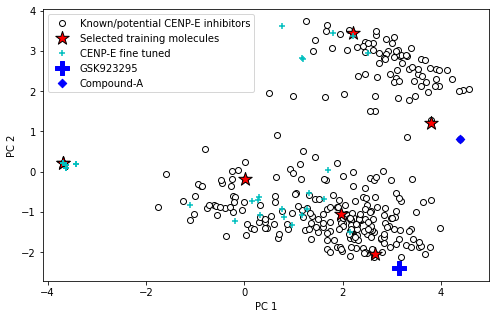

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:Klen, 0], X[:Klen, 1],
            c='w', edgecolors='k', label='Known/potential CENP-E inhibitors')
plt.scatter(X[Klen:Klen + Flen, 0], X[Klen:Klen + Flen, 1],
            s=200, c='r', marker='*', edgecolors='k', label='Selected training molecules')
plt.scatter(X[Klen + Flen:, 0], X[Klen + Flen:, 1],
            c='c', marker='+', label='CENP-E fine tuned')
plt.scatter(CHEMBL_4303470['PC1'],CHEMBL_4303470['PC2'],s=200,marker='P',c='b',label='GSK923295')
plt.scatter(CompoundA['PC1'],CompoundA['PC2'],marker='D',c='b',label='Compound-A')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend();

In [ ]:
idxs = []
for Fbv in Fbvs:
    idx = np.argmax(DataStructs.BulkTanimotoSimilarity(Fbv, Sbvs))
    idxs.append(idx)
nsmols = [smols[idx] for idx in idxs]

In [ ]:
showmols = []
for i, j in zip(fmols, nsmols):
    showmols.append(i)
    showmols.append(j)

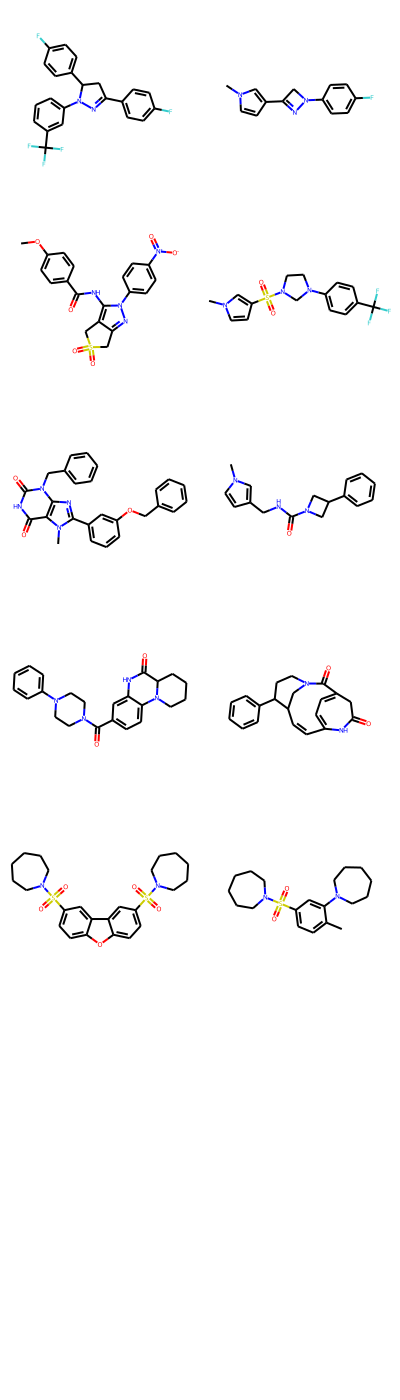

In [ ]:
Draw.MolsToGridImage(showmols, molsPerRow=2)